In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

import os
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split

In [ ]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

In [ ]:
x_test_temp = x_test
y_test_temp = y_test

x_val = x_train[600:620,:,:]
y_val = y_train[600:620]

x_train = x_train[:600,:,:]
y_train = y_train[:600]

x_test = x_test[:100,:,:]
y_test = y_test[:100]

x_test_temp = x_test_temp[:100,:,:]
y_test_temp = y_test_temp[:100]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(600).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(256)

In [ ]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [ ]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [ ]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']             

In [ ]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=40)

Epoch 1/40
10/10 [==============================] - 15s 221ms/step - loss: 3.6871 - dense_4_loss: 2.3044 - dense_1_loss: 2.3045 - dense_3_loss: 2.3045 - dense_4_accuracy: 0.1067 - dense_1_accuracy: 0.1417 - dense_3_accuracy: 0.1117 - val_loss: 3.6736 - val_dense_4_loss: 2.2950 - val_dense_1_loss: 2.2999 - val_dense_3_loss: 2.2955 - val_dense_4_accuracy: 0.1500 - val_dense_1_accuracy: 0.2000 - val_dense_3_accuracy: 0.1500
Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 3.6757 - dense_4_loss: 2.2977 - dense_1_loss: 2.2941 - dense_3_loss: 2.2992 - dense_4_accuracy: 0.1317 - dense_1_accuracy: 0.1417 - dense_3_accuracy: 0.1367 - val_loss: 3.6733 - val_dense_4_loss: 2.2893 - val_dense_1_loss: 2.3217 - val_dense_3_loss: 2.2917 - val_dense_4_accuracy: 0.1500 - val_dense_1_accuracy: 0.0500 - val_dense_3_accuracy: 0.1500
Epoch 3/40
10/10 [==============================] - 0s 41ms/step - loss: 3.6613 - dense_4_loss: 2.2912 - dense_1_loss: 2.2770 - dense_3_loss: 2.2899 - d

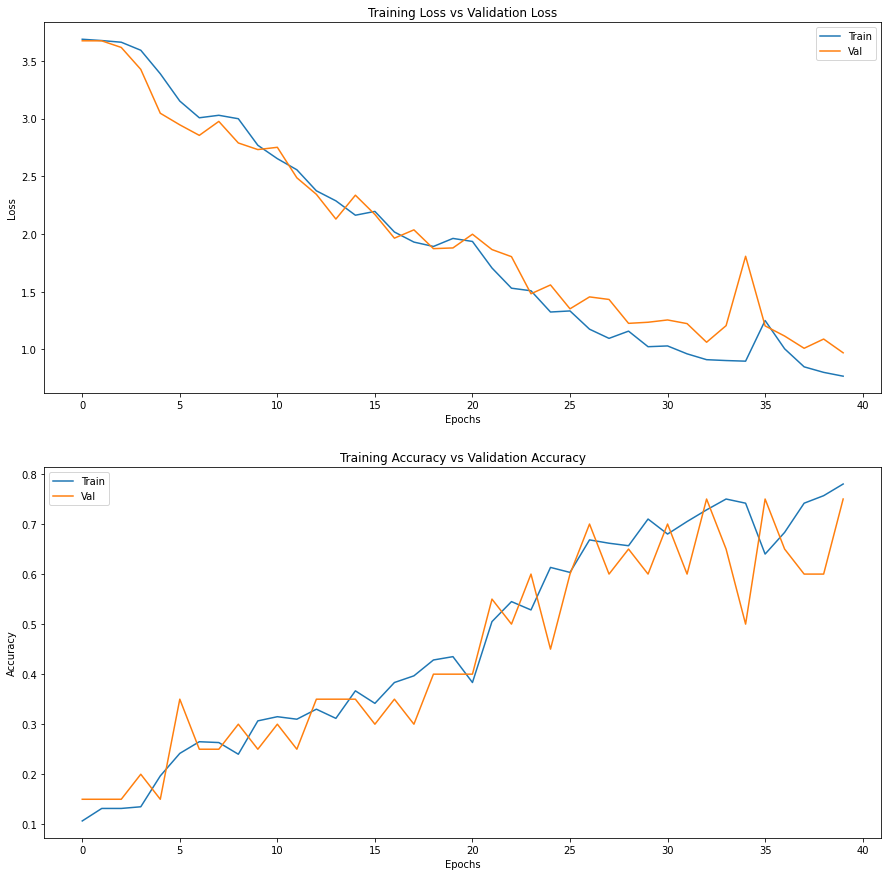

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
#model.evaluate(x_test, y_test)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    #print(prediction[0])
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.cast(y_train, tf.int64)
y_test = tf.cast(y_test, tf.int64)

In [ ]:
perturbations = create_adversarial_pattern(x_test, [y_test,y_test,y_test])

(32, 32, 3)


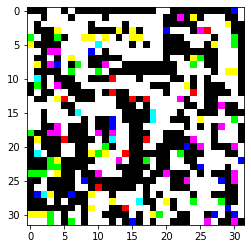

In [ ]:
#check la première perturbation 查看第一个扰动
plt.imshow(perturbations[0],cmap='gray_r')#image en niveaux de gris

print(np.shape(perturbations[0]))

In [ ]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette prédite par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, num = 10):
  fig = plt.figure(figsize=(2*num,3)) # figsize:指定figure的宽和高，单位为英寸
  for i in range(num):   # pre_image的shape的第一个维度就是个数，这里是num
      plt.subplot(1,num,i+1) # 几行几列的 第i+1个图片（从1开始）
      plt.imshow((image[i,:,:]+ 1)/2) # 加1除2: 将生成的-1～1的图片弄到0-1之间,,cmap='gray') # 
      plt.title('{} -> {}'.format(label[i],adv_label[i]))
      plt.axis('off') # 不要坐标
  plt.show()

epsilons = 0:
4/4 [==============================] - 0s 9ms/step


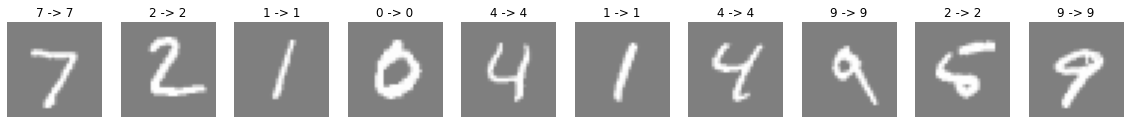

epsilons = 0.05:
4/4 [==============================] - 0s 8ms/step


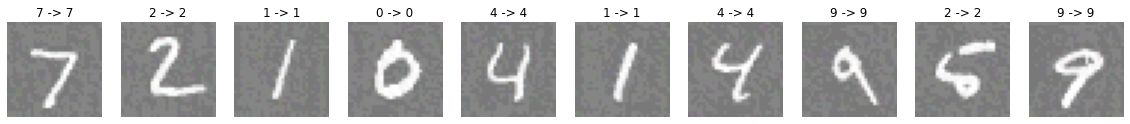

epsilons = 0.1:
4/4 [==============================] - 0s 9ms/step


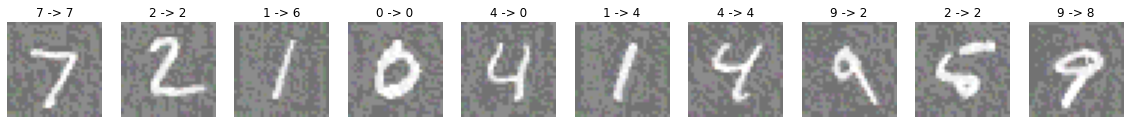

epsilons = 0.15:
4/4 [==============================] - 0s 9ms/step


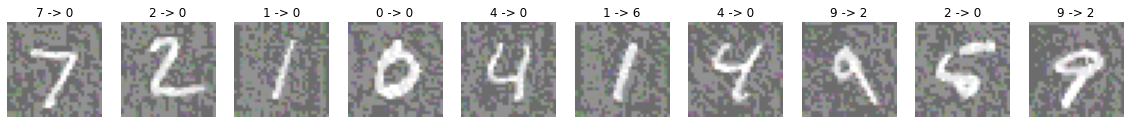

epsilons = 0.2:
4/4 [==============================] - 0s 9ms/step


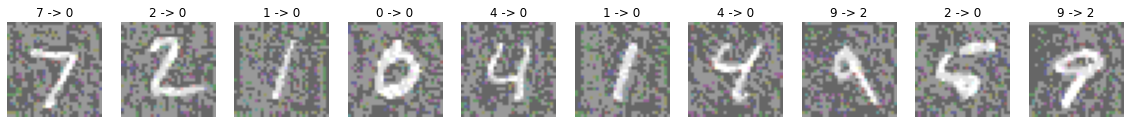

epsilons = 0.25:
4/4 [==============================] - 0s 9ms/step


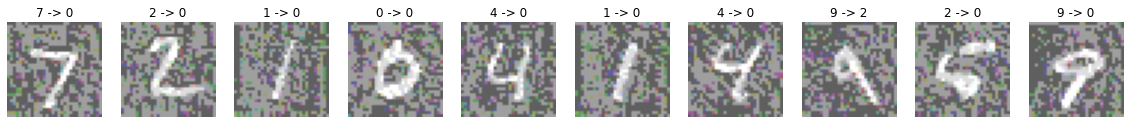

epsilons = 0.3:
4/4 [==============================] - 0s 9ms/step


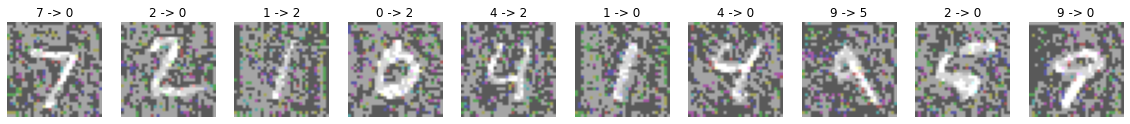

In [ ]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  x_test = tf.clip_by_value(x_test, -1, 1)
  predict_label = model.predict(x_test)
  predict_label = np.array([np.argmax(i) for i in predict_label[0]])

  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_image = x_test_temp + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label[0]])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score = model.evaluate(adv_image,y_test_temp,verbose=0)
  adv_acc_list.append(score[5])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

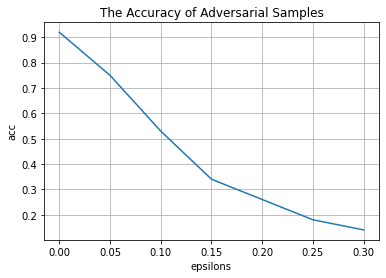

acc [0.9200000166893005, 0.75, 0.5299999713897705, 0.3400000035762787, 0.25999999046325684, 0.18000000715255737, 0.14000000059604645]
eps [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


In [ ]:
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.plot(epsilons,adv_acc_list)
plt.grid()
plt.show()
print('acc',adv_acc_list)
print('eps',epsilons)

In [ ]:
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  x_test_temp = x_test_temp + eps*perturbations
  #x_test = tf.convert_to_tensor(x_test, tf.float32, name='t')
  adv_acc_list.append(model.evaluate(x_test_temp, y_test_temp)[-1])
  #adv_acc_list.append()
#print(adv_acc_list)

4/4 [==============================] - 0s 11ms/step - loss: 35.8568 - dense_4_loss: 21.3273 - dense_1_loss: 26.4450 - dense_3_loss: 21.9866 - dense_4_accuracy: 0.0700 - dense_1_accuracy: 0.0800 - dense_3_accuracy: 0.1000


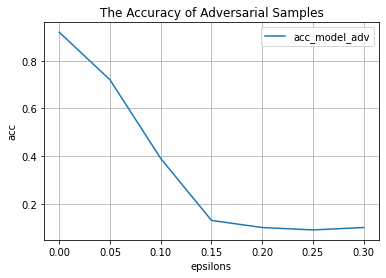

acc [0.9200000166893005, 0.7200000286102295, 0.38999998569488525, 0.12999999523162842, 0.10000000149011612, 0.09000000357627869, 0.10000000149011612]
epsilons [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


In [ ]:
plt.figure()
plt.plot(epsilons,adv_acc_list,label='acc_model_adv')
#plt.plot(epsilons,acc_list,label='acc_model')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',adv_acc_list)
print('epsilons',epsilons)

## L’entraînement contradictoire

In [ ]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.cast(y_train, tf.int64)
y_test = tf.cast(y_test, tf.int64)

In [ ]:
print(x_train.shape)
x_train_adv = x_train[:300,::]
y_train_adv = y_train[:300]
print(x_train_adv.shape)

(600, 32, 32, 3)
(300, 32, 32, 3)


In [ ]:
perturb = create_adversarial_pattern(x_train_adv, [y_train_adv,y_train_adv,y_train_adv])

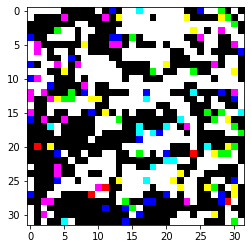

In [ ]:
#check la première perturbation 查看第一个扰动
plt.imshow(perturb[0],cmap='gray_r')#image en niveaux de gris



In [ ]:
train_adv = x_train[:300,:,:] +0.2*perturb
train_train_adv = tf.concat([x_train[300:,:,:], train_adv], 0) #jeu de test + jeu de test avec perturbation （120000 images） 
print(np.shape(train_train_adv))
labels_label_adv = y_train#tf.concat([y_train, y_train], 0) 

(600, 32, 32, 3)


In [ ]:
model_adv2 = Model(inputs = inp, outputs = [out, aux1, aux2])
model_adv2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']           

In [ ]:

model_adv2.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])


In [ ]:
history = model_adv2.fit(train_train_adv, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=40)

Epoch 1/40
10/10 [==============================] - 5s 121ms/step - loss: 5.9071 - dense_4_loss: 3.5454 - dense_1_loss: 3.9387 - dense_3_loss: 3.9333 - dense_4_accuracy: 0.0950 - dense_1_accuracy: 0.0850 - dense_3_accuracy: 0.0733 - val_loss: 3.6049 - val_dense_4_loss: 2.2849 - val_dense_1_loss: 2.1729 - val_dense_3_loss: 2.2269 - val_dense_4_accuracy: 0.1500 - val_dense_1_accuracy: 0.3500 - val_dense_3_accuracy: 0.2500
Epoch 2/40
10/10 [==============================] - 0s 42ms/step - loss: 3.6930 - dense_4_loss: 2.3065 - dense_1_loss: 2.3178 - dense_3_loss: 2.3039 - dense_4_accuracy: 0.0867 - dense_1_accuracy: 0.0733 - dense_3_accuracy: 0.0883 - val_loss: 3.6769 - val_dense_4_loss: 2.3004 - val_dense_1_loss: 2.2876 - val_dense_3_loss: 2.3004 - val_dense_4_accuracy: 0.1000 - val_dense_1_accuracy: 0.1500 - val_dense_3_accuracy: 0.0500
Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 3.6838 - dense_4_loss: 2.3023 - dense_1_loss: 2.3034 - dense_3_loss: 2.3014 - de

epsilons = 0:
4/4 [==============================] - 1s 9ms/step


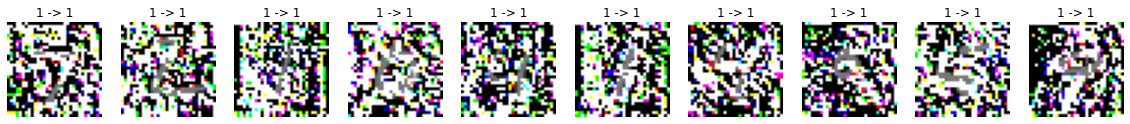

epsilons = 0.05:
4/4 [==============================] - 0s 9ms/step


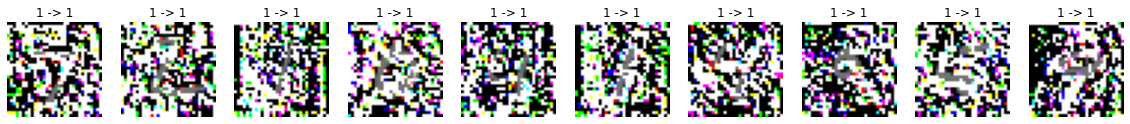

epsilons = 0.1:
4/4 [==============================] - 0s 9ms/step


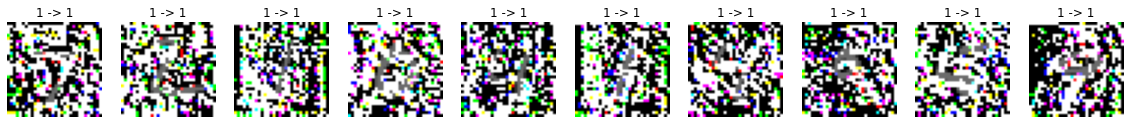

epsilons = 0.15:
4/4 [==============================] - 0s 9ms/step


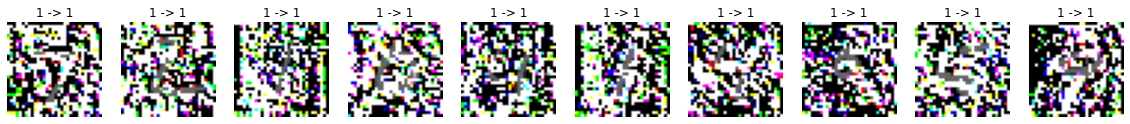

epsilons = 0.2:
4/4 [==============================] - 0s 9ms/step


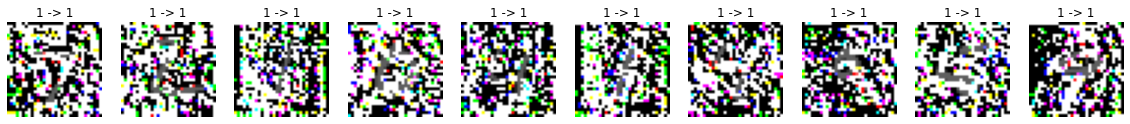

epsilons = 0.25:
4/4 [==============================] - 0s 9ms/step


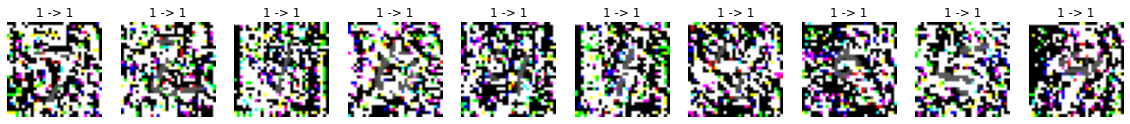

epsilons = 0.3:
4/4 [==============================] - 0s 9ms/step


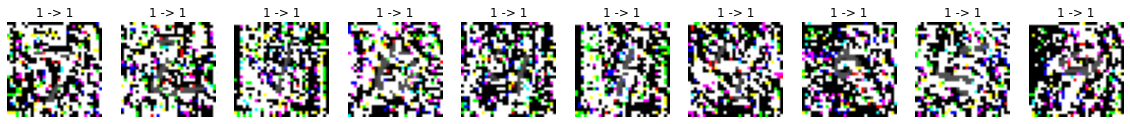

In [ ]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  adv_image = x_test_temp + eps*perturbations      # Générer des adversarial exemple sur les données test
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  predict_label = model.predict(adv_image) 
  predict_label = np.array([np.argmax(i) for i in predict_label[0]])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_predict_label = model_adv2.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label[0]])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score1 = model.evaluate(adv_image,y_test,verbose=0)
  acc_list.append(score1[5])
 
  score = model_adv2.evaluate(adv_image,y_test,verbose=0)
  adv_acc_list.append(score[5])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

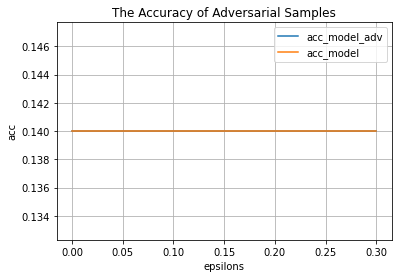

acc [0.14000000059604645, 0.14000000059604645, 0.14000000059604645, 0.14000000059604645, 0.14000000059604645, 0.14000000059604645, 0.14000000059604645]
epsilons [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


In [ ]:
plt.figure()
plt.plot(epsilons,adv_acc_list,label='acc_model_adv')
plt.plot(epsilons,acc_list,label='acc_model')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',adv_acc_list)
print('epsilons',epsilons)